In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# PART I: PROCESS COVID DATA

### read data

In [2]:
df5 = pd.read_csv('covid_countries.csv', parse_dates=['date'])
df6 = pd.read_csv('covid_states.csv', parse_dates=['date'])

### reorder, sort, set index

In [3]:
df5 = df5.iloc[:, [1, 0, 2, 3]]
df6 = df6.iloc[:, [1, 0, 2, 3]]

df5 = df5.sort_values(['country', 'date'], ignore_index=True)
df6 = df6.sort_values(['state', 'date'], ignore_index=True)

df5 = df5.set_index(['country', 'date'])
df6 = df6.set_index(['state', 'date'])

### calculate

In [4]:
def get_new(df): return df.diff()
def get_smooth(df): return df.rolling(28, center=True, win_type='triang').mean()

df5['new ' + df5.columns] = df5.groupby('country').apply(get_new)
df6['new ' + df6.columns] = df6.groupby('state').apply(get_new)

df5['smooth ' + df5.columns] = df5.groupby('country').apply(get_smooth)
df6['smooth ' + df6.columns] = df6.groupby('state').apply(get_smooth)

### organize and inspect

In [5]:
df1 = df5[['new cases', 'smooth new cases']]
df2 = df5[['new deaths', 'smooth new deaths']]
df3 = df6[['new cases', 'smooth new cases']]
df4 = df6[['new deaths', 'smooth new deaths']]

In [6]:
display(df1)
display(df2)
display(df3)
display(df4)

new cases  smooth new cases
country     date                                   
Afghanistan 2020-02-24        NaN               NaN
            2020-02-25        0.0               NaN
            2020-02-26        0.0               NaN
            2020-02-27        0.0               NaN
            2020-02-28        0.0               NaN
...                           ...               ...
Zimbabwe    2021-08-07      445.0               NaN
            2021-08-08      437.0               NaN
            2021-08-09      526.0               NaN
            2021-08-10      405.0               NaN
            2021-08-11      696.0               NaN

[99731 rows x 2 columns]

new deaths  smooth new deaths
country     date                                     
Afghanistan 2020-02-24         NaN                NaN
            2020-02-25         0.0                NaN
            2020-02-26         0.0                NaN
            2020-02-27         0.0                NaN
            2020-02-28         0.0                NaN
...                            ...                ...
Zimbabwe    2021-08-07        21.0                NaN
            2021-08-08        74.0                NaN
            2021-08-09        19.0                NaN
            2021-08-10        31.0                NaN
            2021-08-11        41.0                NaN

[99731 rows x 2 columns]

new cases  smooth new cases
state   date                                   
Alabama 2020-03-11        NaN               NaN
        2020-03-12        1.0               NaN
        2020-03-13        4.0               NaN
        2020-03-14        7.0               NaN
        2020-03-15       13.0               NaN
...                       ...               ...
Wyoming 2021-08-07        0.0               NaN
        2021-08-08        0.0               NaN
        2021-08-09      573.0               NaN
        2021-08-10      300.0               NaN
        2021-08-11      256.0               NaN

[29951 rows x 2 columns]

new deaths  smooth new deaths
state   date                                     
Alabama 2020-03-11         NaN                NaN
        2020-03-12         0.0                NaN
        2020-03-13         0.0                NaN
        2020-03-14         0.0                NaN
        2020-03-15         0.0                NaN
...                        ...                ...
Wyoming 2021-08-07         0.0                NaN
        2021-08-08         0.0                NaN
        2021-08-09         0.0                NaN
        2021-08-10         7.0                NaN
        2021-08-11         0.0                NaN

[29951 rows x 2 columns]

# PART II: CRACKPOT

In [7]:
def format_plot(ax, xformat, xlocate):
    ax.xaxis.set_major_formatter(mdates.DateFormatter(xformat))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(xlocate))
    ax.tick_params('x', labelrotation=45)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
xformat = '%b'
xlocate = np.arange(1, 13, 1)

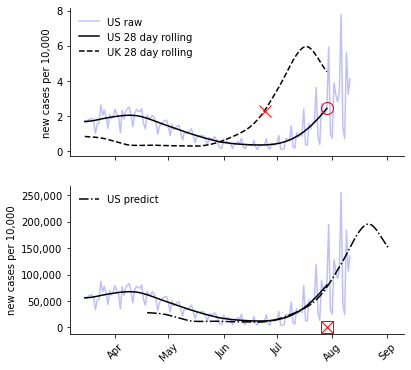

In [8]:
nameA = 'US'
nameB = 'United Kingdom'

popA = 328.2e6
popB = 66.65e6

per = 10_000
days = 150

dfA = df1.loc[nameA].tail(days)
dfB = df1.loc[nameB].tail(days)

dfC = dfA/popA*per
dfD = dfB/popB*per

s1 = dfC.iloc[:, 0]
s2 = dfC.iloc[:, 1]
s3 = dfD.iloc[:, 1]

p2 = s2.dropna().tail(1)
logic = s3 < p2.values[0]
p3 = s3[logic].tail(1)

delta = p2.index[0] - p3.index[0]

s4 = s1*popA/per
s5 = s2*popA/per
s6 = s3*popA/per

s6 = pd.Series(index=s6.index + delta, data=s6.values)
p4 = pd.Series(index=p3.index + delta, data=p3.values)


######


fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

axs[0].plot(s1, 'b-', alpha=0.25, label='US raw')
axs[0].plot(s2, 'k-', alpha=1.00, label='US 28 day rolling')
axs[0].plot(s3, 'k--', alpha=1.00, label='UK 28 day rolling')

axs[0].plot(p2 ,'ro', ms=12, fillstyle='none')
axs[0].plot(p3 ,'rx', ms=12, fillstyle='none')

axs[0].set_ylabel(f'new cases per {per:,}')
axs[0].legend(frameon=False)
format_plot(axs[0], xformat, xlocate)

###

axs[1].plot(s4, 'b-', alpha=0.25)
axs[1].plot(s5, 'k-', alpha=1.00)
axs[1].plot(s6, 'k-.', alpha=1.00, label='US predict')

axs[1].plot(p2 ,'rs', ms=12, fillstyle='none')
axs[1].plot(p4 ,'rx', ms=12, fillstyle='none')

axs[1].set_ylabel(f'new cases per {per:,}')
axs[1].legend(frameon=False)
format_plot(axs[1], xformat, xlocate)

In [9]:
axs

array([<AxesSubplot:ylabel='new cases per 10,000'>,
       <AxesSubplot:ylabel='new cases per 10,000'>], dtype=object)

In [10]:
def format_plot(ax, xformat, xlocate):
    ax.xaxis.set_major_formatter(mdates.DateFormatter(xformat))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(xlocate))
    ax.tick_params('x', labelrotation=45)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    
def plot(ax, df, color, ylabel, xformat, xlocate):
    ax.plot(df.iloc[:, 0], color=color, alpha=0.25)
    ax.plot(df.iloc[:, 1], color='black', alpha=1.00)

    ax.set_ylabel(ylabel)
    format_plot(ax, xformat, xlocate)


args1 = ('blue', 'new cases', '%b', np.arange(1, 13, 1))
args2 = ('red', 'new deaths', '%b', np.arange(1, 13, 1))
args3 = ('blue', 'new cases', '%b', np.arange(1, 13, 4))
args4 = ('red', 'new deaths', '%b', np.arange(1, 13, 4))

In [11]:
days = 365

df1 = df1.groupby('country').tail(days)
df2 = df2.groupby('country').tail(days)
df3 = df3.groupby('state').tail(days)
df4 = df4.groupby('state').tail(days)

Text(0.5, 1.0, 'US')

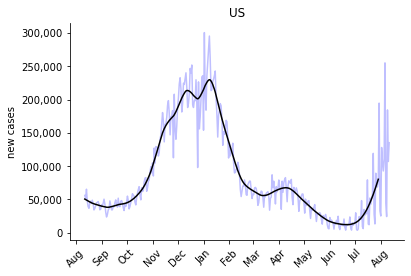

In [12]:
name = 'US'
df = df1.loc[name]

fig, ax = plt.subplots(1, 1)

plot(ax, df, *args1)
ax.set_title(name)

Text(0.5, 1.0, 'US')

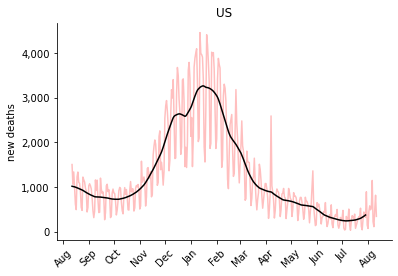

In [13]:
name = 'US'
df = df2.loc[name]

fig, ax = plt.subplots(1, 1)

plot(ax, df, *args2)
ax.set_title(name)

Text(0.5, 1.0, 'Hawaii')

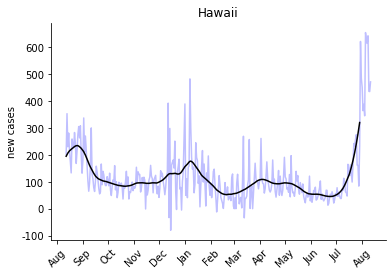

In [14]:
name = 'Hawaii'
df = df3.loc[name]

fig, ax = plt.subplots(1, 1)

plot(ax, df, *args1)
ax.set_title(name)

Text(0.5, 1.0, 'Hawaii')

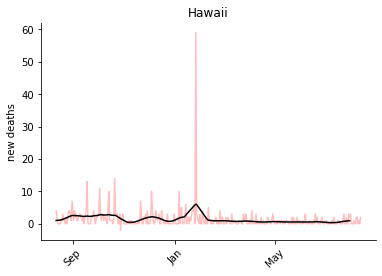

In [15]:
name = 'Hawaii'
df = df4.loc[name]

fig, ax = plt.subplots(1, 1)

plot(ax, df, *args4)
ax.set_title(name)

In [ ]:
def plots(df, names, args):
    nnames = len(names)
    ncols = 5
    nrows = int(np.ceil(nnames/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 2*nrows), constrained_layout=True)
        
    for i in range(nrows):
        for j in range(ncols):
            n = ncols*i + j
            if n < nnames:
                name = names[n]
                plot(axs[i, j], df.loc[name], *args)
                axs[i, j].set_title(name)
            else:
                axs[i, j].axis('off')
            if j != 0:
                axs[i, j].set_ylabel(None)
                
    return fig

In [ ]:
countries = df1['smooth new cases'].groupby('country').max()
countries = np.sort(countries.nlargest(55).index)

states = df3['smooth new cases'].groupby('state').max()
states = np.sort(states.nlargest(55).index)

In [ ]:
fig = plots(df1, countries, args3)

In [ ]:
fig = plots(df2, countries, args4)

In [ ]:
fig = plots(df3, states, args3)

In [ ]:
fig = plots(df4, states, args4)